In [1]:
## Path for modules

import cartopy

import xarray as xr
import sys

import numpy as np
sys.path.insert(0,"/mnt/meom/workdir/henelle/Notebooks/git/xscale")
import xscale
import xscale.spectral.fft as xfft
from matplotlib.colors import LogNorm
import matplotlib.pylab as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

sys.path.insert(0,"/mnt/meom/workdir/henelle/Notebooks/git/powerspectrums")
import Wavenum_freq_spec_func as wfs


In [2]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=2, threads_per_worker=2)

client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38789 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 35.01 GB


## Dataset
### Format netcdf

In [3]:
data_dirT0 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLBT02-S/1h/ACO/'
data_dir00 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLB002-S/1h/ACO/'
dirfilt    = "/mnt/meom/workdir/henelle/eNATL60/JFM-JAS/"

In [4]:
# No tide
tfilename_strain00 = data_dir00 + 'eNATL60ACO-BLB002_y*.1h_strain10m.nc'
tfilename_curl00   = data_dir00 + 'eNATL60ACO-BLB002_y*.1h_curl10m.nc'

In [5]:
# Tide
tfilename_strainT0 = data_dirT0 + 'eNATL60ACO-BLBT02_y*.1h_strain10m.nc'
tfilename_curlT0   = data_dirT0 + 'eNATL60ACO-BLBT02_y*.1h_curl10m.nc'

In [6]:
strain00 = xr.open_mfdataset(tfilename_strain00,combine='by_coords',chunks={'x':500,'y':500})['sostrainoverf'][:]
curl00   = xr.open_mfdataset(tfilename_curl00,combine='by_coords',chunks={'x':500,'y':500})['socurloverf'][:]

In [7]:
strainT0 = xr.open_mfdataset(tfilename_strainT0,combine='by_coords',chunks={'x':500,'y':500})['sostrainoverf'][:]
curlT0   = xr.open_mfdataset(tfilename_curlT0,combine='by_coords',chunks={'x':500,'y':500})['socurloverf'][:]
strainT0

<xarray.DataArray 'sostrainoverf' (time_counter: 4368, y: 1191, x: 781)>
dask.array<concatenate, shape=(4368, 1191, 781), dtype=float32, chunksize=(24, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: y, x
Attributes:
    units:             -
    valid_min:         -1000.0
    valid_max:         1000.0
    long_name:         Relative_Vorticity (strain)
    short_name:        sostrain
    iweight:           1
    online_operation:  N/A
    axis:              TYX
    savelog10:         0.0

In [8]:
# Gives Memory Error when executing [14]
navlat = xr.open_mfdataset(tfilename_strain00,combine='by_coords',chunks={'x':500,'y':500})['nav_lat']
navlon = xr.open_mfdataset(tfilename_strain00,combine='by_coords',chunks={'x':500,'y':500})['nav_lon']

In [ ]:
# Occasional Memory Error when executing [14] as well 

#tfile = dirfilt + 'eNATL60ACO-BLB002_y2009_JAS.1d_strain_after_mean10m.nc'
#navlat = xr.open_dataset(tfile)['nav_lat']
#navlon = xr.open_dataset(tfile)['nav_lon']

In [9]:
T=2*np.pi/(1E-4)

In [10]:
strainT0

<xarray.DataArray 'sostrainoverf' (time_counter: 4368, y: 1191, x: 781)>
dask.array<concatenate, shape=(4368, 1191, 781), dtype=float32, chunksize=(24, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: y, x
Attributes:
    units:             -
    valid_min:         -1000.0
    valid_max:         1000.0
    long_name:         Relative_Vorticity (strain)
    short_name:        sostrain
    iweight:           1
    online_operation:  N/A
    axis:              TYX
    savelog10:         0.0

In [11]:
wstrainT0 = strainT0.window
wstrainT0.set(n=48,dim='time_counter', cutoff=T)
strainT0_filt = wstrainT0.convolve()
strainT0_filt

<xarray.DataArray 'sostrainoverf' (time_counter: 4368, y: 1191, x: 781)>
dask.array<mul, shape=(4368, 1191, 781), dtype=float32, chunksize=(24, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: y, x

In [12]:
wstrain00 = strain00.window
wstrain00.set(n=48,dim='time_counter', cutoff=T)
strain00_filt = wstrain00.convolve()
strain00_filt

<xarray.DataArray 'sostrainoverf' (time_counter: 4368, y: 1191, x: 781)>
dask.array<mul, shape=(4368, 1191, 781), dtype=float32, chunksize=(24, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: y, x

In [13]:
wcurlT0 = curlT0.window
wcurlT0.set(n=48,dim='time_counter', cutoff=T)
curlT0_filt = wcurlT0.convolve()
curlT0_filt

<xarray.DataArray 'socurloverf' (time_counter: 4368, y: 1191, x: 781)>
dask.array<mul, shape=(4368, 1191, 781), dtype=float32, chunksize=(24, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: y, x

In [14]:
wcurl00 = curl00.window
wcurl00.set(n=48,dim='time_counter', cutoff=T)
curl00_filt = wcurl00.convolve()
curl00_filt

<xarray.DataArray 'socurloverf' (time_counter: 4368, y: 1191, x: 781)>
dask.array<mul, shape=(4368, 1191, 781), dtype=float32, chunksize=(24, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: y, x

In [15]:
#box = (-34.5,-32.0,34.8,38.4)
box = (-31,-28,33,36)

domain = (box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
where  = np.where(domain)
print(where)

#lats = navlat[where]
#lons = navlon[where]

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [19]:
#ind = np.unravel_index(np.argmin(lats, axis=None), lats.shape)
#jmin = where[0][ind[0]]
#ind = np.unravel_index(np.argmax(lats, axis=None), lats.shape)
#jmax = where[0][ind[0]]
#ind = np.unravel_index(np.argmin(lons, axis=None), lons.shape)
#imin = where[1][ind[1]]
#ind = np.unravel_index(np.argmax(lons, axis=None), lons.shape)
#imax = where[1][ind[1]]

# Alternative for larger boxes (to avoid MemoryError)
jmin = where[0][0]
jmax = where[0][-1]
imin = where[1][0]
imax = where[1][-1]

In [20]:
print('jmin = '+str(jmin)+'; jmax = '+str(jmax))
print('imin = '+str(imin)+'; imax = '+str(imax))

jmin = 0; jmax = 4367
imin = 667; imax = 882


In [21]:
strainT0_filt

<xarray.DataArray 'sostrainoverf' (time_counter: 4368, y: 1191, x: 781)>
dask.array<mul, shape=(4368, 1191, 781), dtype=float32, chunksize=(24, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: y, x

In [22]:
strainT0_filtbox = strainT0_filt[:,jmin:jmax+1,imin:imax+1]
curlT0_filtbox   = curlT0_filt  [:,jmin:jmax+1,imin:imax+1]

# This doesn't work for me because when I execute 
# dx,dy = wfs.get_dx_dy(strainT0_filtbox[0]) in the next cell
# it doesn't find data.nav_lon because for me it should be data.x I guess. So I just change this in AJ's function?
strainT0_filtbox[0]

<xarray.DataArray 'sostrainoverf' (y: 1191, x: 114)>
dask.array<getitem, shape=(1191, 114), dtype=float32, chunksize=(500, 114), chunktype=numpy.ndarray>
Coordinates:
    time_counter  datetime64[ns] 2009-07-01T00:30:00
Dimensions without coordinates: y, x

In [23]:
strainT0_filtbox[0]

<xarray.DataArray 'sostrainoverf' (y: 1191, x: 114)>
dask.array<getitem, shape=(1191, 114), dtype=float32, chunksize=(500, 114), chunktype=numpy.ndarray>
Coordinates:
    time_counter  datetime64[ns] 2009-07-01T00:30:00
Dimensions without coordinates: y, x

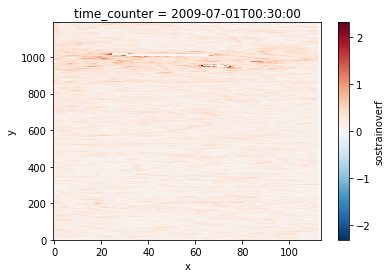

In [24]:
strainT0_filtbox[0].plot()

In [ ]:
dx,dy = wfs.get_dx_dy(strainT0_filtbox[0])
strainT0_No_NaN = strainT0_filtbox.interpolate_na(dim='y')
strainT0_dtr = wfs.detrendn(strainT0_No_NaN,axes=[0,1,2])
strainT0_wdw = wfs.apply_window(strainT0_dtr, strainT0_dtr.dims, window_type='hanning')
strainT0hat = xfft.fft(strainT0_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
strainT0_psd = xfft.psd(strainT0hat)
strainT0_frequency,kx,ky = wfs.get_f_kx_ky(strainT0hat)
strainT0filt_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
strainT0filt_psd_np = strainT0_psd.values
strainT0filt_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,strainT0filt_wavenumber,strainT0filt_psd_np)

dx,dy = wfs.get_dx_dy(curlT0_filtbox[0])
curlT0_No_NaN = curlT0_filtbox.interpolate_na(dim='y')
curlT0_dtr = wfs.detrendn(curlT0_No_NaN,axes=[0,1,2])
curlT0_wdw = wfs.apply_window(curlT0_dtr, curlT0_dtr.dims, window_type='hanning')
curlT0hat = xfft.fft(curlT0_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
curlT0_psd = xfft.psd(curlT0hat)
curlT0_frequency,kx,ky = wfs.get_f_kx_ky(curlT0hat)
curlT0filt_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
curlT0filt_psd_np = curlT0_psd.values
curlT0filt_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,curlT0filt_wavenumber,curlT0filt_psd_np)

KEtidefilt_wavenum_freq_spectrum=0.5*(strainT0filt_wavenum_freq_spectrum+curlT0filt_wavenum_freq_spectrum)

In [ ]:
KEtidefilt_wavenum_freq_spectrum